# 使用Haar特征进行人脸检测

### 1.读入照片，计算积分图

积分图形状: (242, 323)
积分图内容:
[[       0        0        0 ...        0        0        0]
 [       0      207      410 ...    69631    69859    70092]
 [       0      413      818 ...   138103   138555   139016]
 ...
 [       0    34784    69745 ... 11337658 11390408 11444069]
 [       0    34805    69787 ... 11342098 11394880 11448581]
 [       0    34858    69851 ... 11346368 11399165 11452926]]
积分图计算完成。


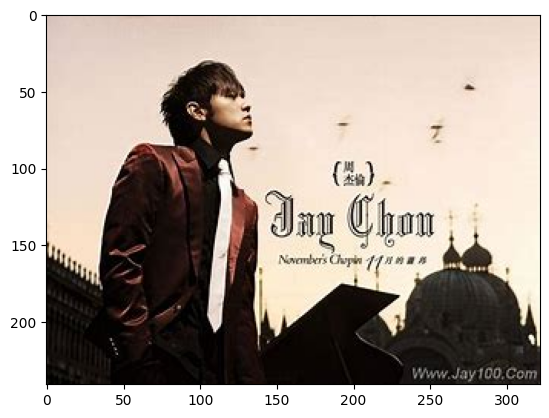

In [198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def calculate_integral_image(image_path):
    # 读入图像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("无法读取图像，请检查路径是否正确。")
    
    # 计算积分图
    integral_image = cv2.integral(image)
    
    return integral_image

# 示例使用
image_path = 'Jay.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 转换颜色空间从BGR到RGB
original_img = img.copy()
plt.imshow(img)
integral_image = calculate_integral_image(image_path)
print("积分图形状:", integral_image.shape)
print("积分图内容:")
print(integral_image)
print("积分图计算完成。")

### 2. 计算Haar特征

检测到的人脸区域: [(123, 0, 100, 100), (124, 0, 100, 100), (125, 0, 100, 100), (126, 0, 100, 100), (127, 0, 100, 100), (128, 0, 100, 100), (129, 0, 100, 100), (130, 0, 100, 100), (131, 0, 100, 100), (132, 0, 100, 100), (133, 0, 100, 100), (134, 0, 100, 100), (135, 0, 100, 100), (136, 0, 100, 100), (137, 0, 100, 100), (138, 0, 100, 100), (139, 0, 100, 100), (140, 0, 100, 100), (141, 0, 100, 100), (142, 0, 100, 100), (143, 0, 100, 100), (144, 0, 100, 100), (145, 0, 100, 100), (146, 0, 100, 100), (147, 0, 100, 100), (148, 0, 100, 100), (149, 0, 100, 100), (150, 0, 100, 100), (151, 0, 100, 100), (152, 0, 100, 100), (153, 0, 100, 100), (154, 0, 100, 100), (155, 0, 100, 100), (156, 0, 100, 100), (157, 0, 100, 100), (158, 0, 100, 100), (159, 0, 100, 100), (160, 0, 100, 100), (161, 0, 100, 100), (162, 0, 100, 100), (163, 0, 100, 100), (164, 0, 100, 100), (165, 0, 100, 100), (166, 0, 100, 100), (167, 0, 100, 100), (168, 0, 100, 100), (169, 0, 100, 100), (170, 0, 100, 100), (171, 0, 100, 100), (172, 0, 

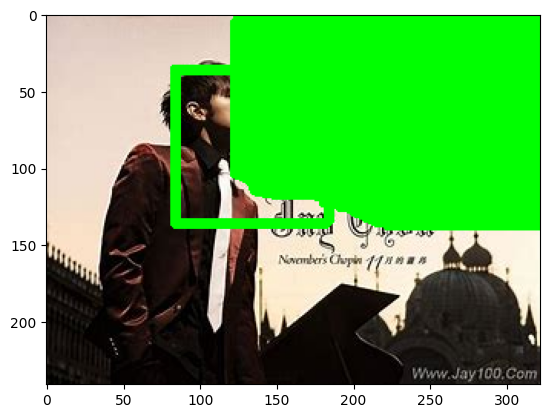

In [199]:
def calculate_haar_feature(integral_image, x, y, width, height):
    """
    计算一个上黑下白的Haar特征。
    """
    # 确保窗口在图像范围内
    if x + width > integral_image.shape[1] or y + height > integral_image.shape[0]:
        return 0

    # 计算上半部分的和
    top_sum = integral_image[y + height // 2, x + width] - integral_image[y + height // 2, x] - integral_image[y, x + width] + integral_image[y, x]

    # 计算下半部分的和
    bottom_sum = integral_image[y + height, x + width] - integral_image[y + height, x] - integral_image[y + height // 2, x + width] + integral_image[y + height // 2, x]

    # Haar特征值
    haar_value = bottom_sum - top_sum

    return haar_value

def detect_faces_with_haar(integral_image, window_size, threshold):
    """
    使用滑动窗口方法在积分图上检测人脸。
    """
    detected_faces = []
    step_size = 1  # 滑动窗口的步长

    for y in range(0, integral_image.shape[0] - window_size[1], step_size):
        for x in range(0, integral_image.shape[1] - window_size[0], step_size):
            haar_value = calculate_haar_feature(integral_image, x, y, window_size[0], window_size[1])
            if haar_value > threshold:     
               detected_faces.append((x, y, window_size[0], window_size[1]))

    return detected_faces

window_size = (100, 100)  # 窗口大小
threshold = 10000 # 阈值
detected_faces = detect_faces_with_haar(integral_image, window_size, threshold)
print("检测到的人脸区域:", detected_faces)
for face in detected_faces:
    x, y, width, height = face
    cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 2)
plt.imshow(img)

### 3. 非极大值抑制


经过非极大值抑制后的人脸区域: [[222, 39, 100, 100], [83, 38, 100, 100]]


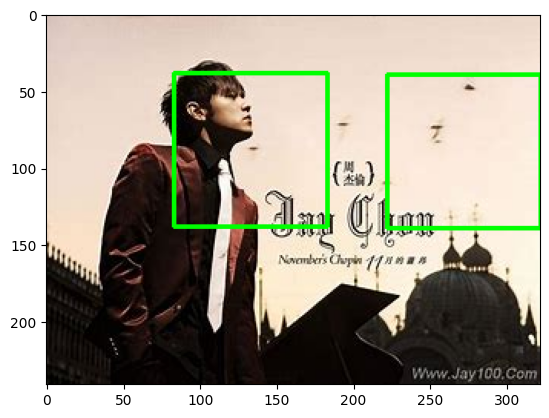

In [200]:
def non_maximum_suppression(boxes, overlap_thresh):
    """
    对检测到的框进行非极大值抑制。
    :param boxes: 检测到的框列表，每个框用(x, y, w, h)表示
    :param overlap_thresh: 重叠阈值
    :return: 经过非极大值抑制后的框列表
    """
    if len(boxes) == 0:
        return []

    # 将框转换为numpy数组
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]

    # 计算每个框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    # 按照框的右下角坐标排序
    order = np.argsort(y2)

    keep = []
    while order.size > 0:
        i = order[-1]
        keep.append(i)

        # 计算当前框与其他框的交集
        xx1 = np.maximum(x1[i], x1[order[:-1]])
        yy1 = np.maximum(y1[i], y1[order[:-1]])
        xx2 = np.minimum(x2[i], x2[order[:-1]])
        yy2 = np.minimum(y2[i], y2[order[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        # 计算交并比
        iou = inter / (areas[i] + areas[order[:-1]] - inter)

        # 保留交并比小于阈值的框
        order = order[np.where(iou <= overlap_thresh)[0]]

    return boxes[keep].tolist()

# 示例使用
overlap_thresh = 0.1  # 重叠阈值
final_faces = non_maximum_suppression(detected_faces, overlap_thresh)
print("经过非极大值抑制后的人脸区域:", final_faces)
for face in final_faces:
    x, y, width, height = face
    cv2.rectangle(original_img, (x, y), (x + width, y + height), (0, 255, 0), 2)
plt.imshow(original_img)
